# Imports and loading data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (accuracy_score,
                             f1_score,
                             precision_score,
                             recall_score,
                             classification_report,
                             #plot_confusion_matrix,
                             ConfusionMatrixDisplay)

sns.set_style('darkgrid')
%matplotlib inline

In [2]:
pkmn = pd.read_csv('./pokemon_data/Pokemon_with_correct_pkmn_numbers.csv')
pkmn.rename(columns=(
                    {'#':'Number', 'Total':'Total Stats'}),
            inplace=True)
# Usually rows in a Pandas dataframe (df) start at 0, but pokemon numbers 
# start at 1.  The next line of code makes the df row index start at 1 
# and this will help us with joins later.  (joining pkmn and combats tables)
pkmn.index = pkmn.index + 1

combats = pd.read_csv("./pokemon_data/combats.csv")

## Pokemon table

In [3]:
pkmn.head()

,Number,Name,Type 1,Type 2,Total Stats,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
1,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
2,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
3,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
4,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
5,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Note that values in the Number column are not unique, as pokemon like Venusaur and Mega Venusaur both have Number 3, but their row index is unique.  This is important bc our combats data keeps track of winners using a pokemon's row index, NOT its pokemon number.  

In [4]:
print(F"The pkmn df has row index starting at {pkmn.index.min()} and ending at {pkmn.index.max()}")
print(F"While the min pkmn. Number is {pkmn.Number.min()} and the max pkmn.Number is {pkmn.Number.max()}")

The pkmn df has row index starting at 1 and ending at 800
While the min pkmn. Number is 1 and the max pkmn.Number is 721


Further proof that pokemon numbers are NOT unique, while row indexes are unique.

## Combats Table

In [5]:
combats.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [6]:
combats['Winner'].describe()

count    50000.000000
mean       408.890100
std        231.159961
min          1.000000
25%        206.000000
50%        422.000000
75%        606.000000
max        800.000000
Name: Winner, dtype: float64

Looking at our combats data, our max number for Winner is 800.  This is because a winning pokemon is identified by the row index in the pkmn df.  Winner DOES NOT correspond to pkmn Number.

# Joins

## Identify names of pokemon in winning battles

In [7]:
# Join combats to pkmn table using the unique row indices (1, 800) 
# for the pkmn table.  This ensures that a pokemon like 
# Venusaur vs. Mega Venusaur will each have their own row 
# and appropriate number of wins. 
combats_join = pd.merge(combats, 
                        pkmn[['Name']], left_on='Winner', 
                        right_index=True, 
                        how='left')
combats_join.rename(columns={'Name':"winner_name"}, inplace=True)
combats_join.head()

,First_pokemon,Second_pokemon,Winner,winner_name
0,266,298,298,Nuzleaf
1,702,701,701,Terrakion
2,191,668,668,Beheeyem
3,237,683,683,Druddigon
4,151,231,151,Omastar


## Identifying number of wins for each pokemon from battles data

The pkmn table contains all pokemon, however the combats table only has pokemon that were used in a battle.  There are many pokemon that weren't used in combat and the combats table has no data on.  To preserve all 800 unique Pokemon from pkmn table after the join, we need to use a left join.  Any Pokemon that aren't found in the right df (winners) will get a NaN value that we'll replace with 0.

In [8]:
winners = combats_join['Winner'].value_counts()
pkmn_join = pd.merge(pkmn, winners, 
                     how='left', 
                     left_index=True, 
                     right_index=True)
pkmn_join.rename(mapper={'Winner':'Wins'}, 
                 axis=1, 
                 inplace=True)
# If a pokemon has NaN for Wins, we have no data on combats 
# for the pokemon and can be considered as having 0 wins.
pkmn_join['Wins'].fillna(value=0, inplace=True)
pkmn_join.sort_values('Wins', ascending=False)

,Number,Name,Type 1,Type 2,Total Stats,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Wins
163,150,Mewtwo,Psychic,NaN,680,106,110,90,154,90,130,1,True,152.0
154,142,Aerodactyl,Rock,Flying,515,80,105,65,60,75,130,1,False,136.0
438,392,Infernape,Fire,Fighting,534,76,104,71,104,71,108,4,False,136.0
428,385,Jirachi,Steel,Psychic,600,100,100,100,100,100,100,3,True,134.0
314,289,Slaking,Normal,NaN,670,150,160,100,95,65,100,3,False,133.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,556,Maractus,Grass,NaN,461,75,86,67,106,67,60,5,False,0.0
183,168,Ariados,Bug,Poison,390,70,90,70,60,60,40,2,False,0.0
322,297,Hariyama,Fighting,NaN,474,144,120,60,40,60,50,3,False,0.0
66,60,Poliwag,Water,NaN,300,40,50,40,40,40,90,1,False,0.0


In [9]:
# Check to see if join was done correctly
num_combats = len(combats)
total_wins = pkmn_join['Wins'].sum()

print(num_combats == total_wins)

True


It looks like all the data was joined correctly

# Which numerical features are most highly correlated with a pokemon being legendary?

In [10]:
pkmn_corr = pkmn_join.corr()

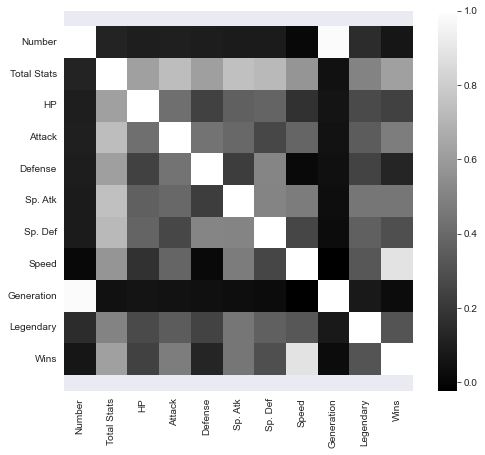

In [11]:
fig, ax = plt.subplots(1,1, figsize=(9,7))
sns.heatmap(pkmn_corr, 
            cmap='gist_gray', 
            square=True, 
            ax=ax
            #, annot=True, fmt='.2f', annot_kws={'size':12}
           )
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)
plt.show();

Legendary seems most highly correlated with Total Stats, Sp. Atk, Sp. Def, Attack, Speed, and Wins

In [12]:
pkmn_corr['Legendary'].sort_values(ascending=False)

Legendary      1.000000
Total Stats    0.501758
Sp. Atk        0.448907
Sp. Def        0.363937
Attack         0.345408
Speed          0.326715
Wins           0.312999
HP             0.273620
Defense        0.246377
Number         0.153396
Generation     0.079794
Name: Legendary, dtype: float64

## Pairplots of variables most highly correlated with Legendary

In [13]:
most_corr_num_features = pkmn_corr['Legendary'].sort_values(ascending=False)[1:7].index.values

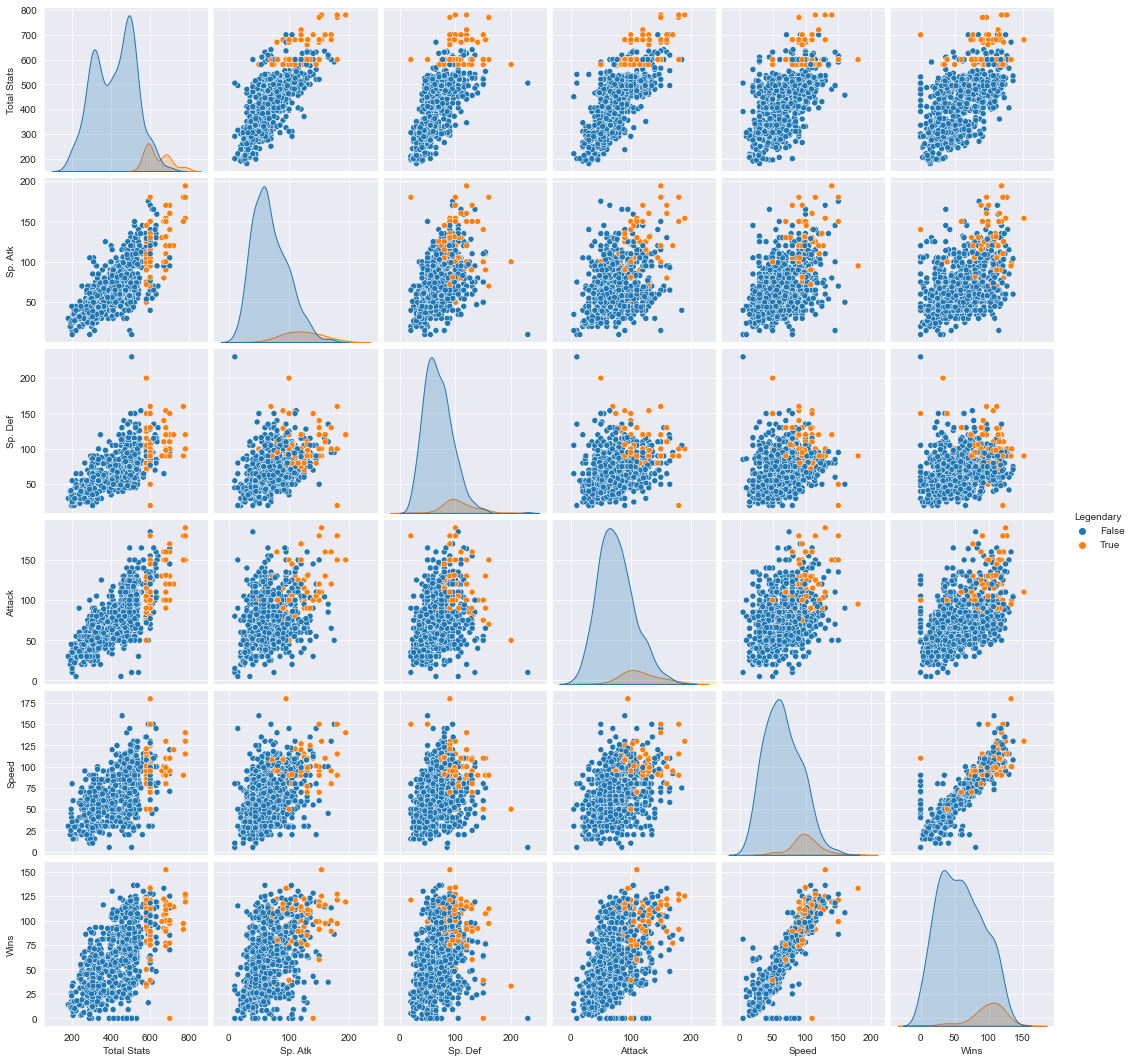

In [14]:
sns.pairplot(pkmn_join[
                            ['Total Stats',
                             'Sp. Atk', 
                             'Sp. Def', 
                             'Attack', 
                             'Speed', 
                             'Wins', 
                             'Legendary']
                            ], 
                             hue='Legendary');

For most, if not all plots, we see a tendency for Legendary pokemon to cluster in the upper right of each scatter plot, indicating that Legendary pokemon tend to have high stats as compared to non-legendary pokemon.  These predictors are probably going to be the most important for our model's performance.

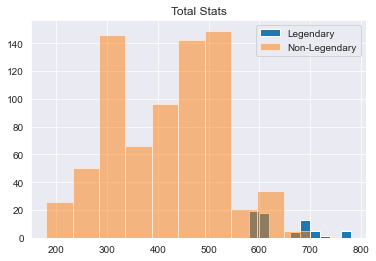

In [15]:
fig, ax = plt.subplots(1,1)
pkmn_join[pkmn_join['Legendary']==True].hist(column='Total Stats', 
                                                       ax=ax)
pkmn_join[pkmn_join['Legendary']==False].hist(column='Total Stats', 
                                                        ax=ax, alpha=0.5)
plt.legend(['Legendary', 'Non-Legendary'])
plt.show();

Focusing on the aggregated total stats, we see legendary pokemon are towards the top.  I expect this predcitor will be very useful in our model.

# kNN classification - Predicting legendary status from pokemon stats (HP, Defense, ..., num_wins_in_combat)

In [16]:
pkmn_join_copy = pkmn_join.copy(deep=True)

numeric_cols_labels = ['Total Stats', 
                       'HP', 'Attack', 
                       'Defense', 
                       'Sp. Atk', 
                       'Sp. Def', 
                       'Speed', 
                       'Wins']

numeric_cols = pkmn_join_copy.loc[:, numeric_cols_labels]

## Scale and transform the data

kNN classification requires quantitative values as input.  For categorical data, we can convert to dummy variables, which are quantitative, and allow for the use of categorical data in the model. 

Note, I decide to exclude the "Generation" column.  I want the model to work without knowing which generation a pokemon comes from because I want the model to be generalizable to future generations of pokemon as well.  Lataer, I plan to test the model's performance on generation 8 pokemon.

In [17]:
categorical_cols = pkmn_join_copy.loc[:, ['Type 1', 'Type 2']]
categorical_cols_labels = list(categorical_cols.columns)
orig_with_dummies = pd.get_dummies(
                                    pkmn_join.drop(
                                        ['Number', 'Name', 'Legendary'], 
                                        axis=1), 
                                    columns=categorical_cols_labels
                                    )

kNN classification compares Euclidean distance between points when classifying a prediction.  Some of our numeric values are on a larger scale than others, which will have an impact on Euclidean distance, and may skew our understanding of the strength of a given predictor in the model.  To overcome this issue, we transform our numeric data so all predictors are on the same scale.

In [18]:
scaled_with_dummies = orig_with_dummies.copy()

scaler = StandardScaler()
scaler.fit(numeric_cols)
scaled_with_dummies.loc[:, numeric_cols_labels] = scaler.transform(numeric_cols)

In [ ]:
# scaled_with_dummies = orig_with_dummies.copy()

Lastly, we separate our target labels from the rest of the dataset

In [20]:
orig_with_dummies

,Total Stats,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Wins,Type 1_Bug,...,Type 2_Ghost,Type 2_Grass,Type 2_Ground,Type 2_Ice,Type 2_Normal,Type 2_Poison,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water
1,318,45,49,49,65,65,45,1,37.0,0,...,0,0,0,0,0,1,0,0,0,0
2,405,60,62,63,80,80,60,1,46.0,0,...,0,0,0,0,0,1,0,0,0,0
3,525,80,82,83,100,100,80,1,89.0,0,...,0,0,0,0,0,1,0,0,0,0
4,625,80,100,123,122,120,80,1,70.0,0,...,0,0,0,0,0,1,0,0,0,0
5,309,39,52,43,60,50,65,1,55.0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,600,50,100,150,100,150,50,6,39.0,0,...,0,0,0,0,0,0,0,0,0,0
797,700,50,160,110,160,110,110,6,116.0,0,...,0,0,0,0,0,0,0,0,0,0
798,600,80,110,60,150,130,70,6,60.0,0,...,1,0,0,0,0,0,0,0,0,0
799,680,80,160,60,170,130,80,6,89.0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
target_df = pkmn_join_copy['Legendary']

### Checking the results

In [ ]:
scaled_with_dummies.head()

In [ ]:
scaled_with_dummies.columns

## Building Models

First, I'm going to consider building a model that uses each stat.  The extra granularity may help build a better model, but it will be more complex as a result.  I'll first start using all available features, but then see what happens when I narrow down to focusing on the numerical values that are most highly correlated with legendary: Sp. Atk, Sp. Def, Attack, Speed, and Wins.  I'm also especially interested in how well the model performs if I only use the `Total Stats` predictor.

### Creating a model using all features except total stats.

In [ ]:
# Drop Total Stats column as we have more granularity 
# if we look at each stat individually.  We can consider 
# building a model that looks at total stats later on and 
# compare performance to the model we build now.
scaled_with_dummies_no_total = scaled_with_dummies.drop('Total Stats', 
                                                        axis=1)

In [ ]:
scaled_with_dummies_no_total.head()

#### Which n_neighbors is most optimal and what is the performance?

In [ ]:
knn_all_features_no_total = KNeighborsClassifier()

param_grid = {'n_neighbors': np.arange(3,101,2)}

knn_all_features_no_total_gscv = GridSearchCV(knn_all_features_no_total, 
                                              param_grid, cv=5)
knn_all_features_no_total_gscv.fit(scaled_with_dummies_no_total, 
                                   target_df)

print(F"Optimal n_neighbors for model: {knn_all_features_no_total_gscv.best_params_}")
print(F"Highest model performance: {knn_all_features_no_total_gscv.best_score_}")

This will establish our baseline.  Let's see if we can build a model that is less complex and performs better.

### Creating a model which swaps HP, Attack, Defense, Sp. Attack, and Sp. Defense for their aggregate `Total Stats`.

In [ ]:
stats_labels = numeric_cols_labels[1:]
scaled_with_dummies_total = scaled_with_dummies.drop(stats_labels, 
                                                     axis=1)

#### Which n_neighbors is most optimal and what is the performance?

In [ ]:
knn_all_features_with_total = KNeighborsClassifier()

knn_all_features_with_total_gscv = GridSearchCV(knn_all_features_with_total, 
                                                param_grid, cv=5)
knn_all_features_with_total_gscv.fit(scaled_with_dummies_total, 
                                     target_df)

print(F"Optimal n_neighbors for model: {knn_all_features_with_total_gscv.best_params_}")
print(F"Highest model performance: {knn_all_features_with_total_gscv.best_score_}")

Now the most optimal model for this new set of predictors sees worse performance and is more complex, with an optimal n_neighbors of 41.  I'd be a little concerned this model is overfitting.

### Creating a model using the predictors that were highly correlated with `Legendary`: `Total Stats`, `Sp. Atk`, `Sp. Def`, `Attack`, `Speed`, and `Wins`

In [ ]:
individual_stats_and_wins = scaled_with_dummies[
                                                ['Sp. Atk', 
                                                 'Sp. Def', 
                                                 'Attack', 
                                                 'Speed', 
                                                 'Wins']
                                                ]

#### Which n_neighbors is most optimal and what is the performance?

In [ ]:
knn_individual_stats_and_wins = KNeighborsClassifier()

knn_individual_stats_and_wins_gscv = GridSearchCV(knn_individual_stats_and_wins, 
                                                  param_grid, 
                                                  cv=5)
knn_individual_stats_and_wins_gscv.fit(individual_stats_and_wins, 
                                       target_df)

print(F"Optimal n_neighbors for model: {knn_individual_stats_and_wins_gscv.best_params_}")
print(F"Highest model performance: {knn_individual_stats_and_wins_gscv.best_score_}")

We're starting to see better performance with this set of predictors.  Now the optimal n_neighbors is only 15, with slightly better performance than our previous models, but we might be able to do better still.

### Creating a model using only `Total Stats` and `Wins`

In [ ]:
total_stats_and_wins = scaled_with_dummies[
                                            ['Total Stats', 
                                             'Wins']
                                            ]

#### Which n_neighbors is most optimal and what is the performance?

In [ ]:
knn_total_stats_and_wins = KNeighborsClassifier()

knn_total_stats_and_wins_gscv = GridSearchCV(knn_total_stats_and_wins, 
                                             param_grid, 
                                             cv=5)
knn_total_stats_and_wins_gscv.fit(total_stats_and_wins, 
                                  target_df)

print(F"Optimal n_neighbors for model: {knn_total_stats_and_wins_gscv.best_params_}")
print(F"Highest model performance: {knn_total_stats_and_wins_gscv.best_score_}")

Using just `Total Stats` and `Wins` as predictors results in a model that is much less complex, having an optimal n_neighbors of 3, and better performance than all our previous models.  Using these predictors for our model is best so far.

### Creating a model using only `Total Stats`

In [ ]:
total_stats = scaled_with_dummies.loc[:,'Total Stats']
total_stats = np.array(total_stats).reshape(-1,1)

#### Which n_neighbors is most optimal and what is the performance?

In [ ]:
knn_total_stats = KNeighborsClassifier()

knn_total_stats_gscv = GridSearchCV(knn_total_stats, 
                                    param_grid, 
                                    cv=5)
knn_total_stats_gscv.fit(total_stats, 
                         target_df)

print(F"Optimal n_neighbors for model: {knn_total_stats_gscv.best_params_}")
print(F"Highest model performance: {knn_total_stats_gscv.best_score_}")

Slightly better performance, with a slightly more complex n_neighbors of 5, but now the model uses only one predictor.  Using predictors of `Total Stats`, or `Total Stats` and `Wins`, both seem like reasonable choices for our final model.  Let's investigate their performance a little further.

## Further investigating performance of our two top models

### Model: Total stats and wins

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(total_stats_and_wins, 
                                                    target_df, 
                                                    test_size=0.2, 
                                                    random_state=5)

#### Fit and train the model, then generate predictions

In [ ]:
knn_total_stats_and_wins.set_params(n_neighbors=3)
knn_total_stats_and_wins.fit(X_train, y_train)
y_preds = knn_total_stats_and_wins.predict(X_test)

#### Check performance metrics

In [ ]:
knn_total_stats_and_wins_score = knn_total_stats_and_wins.score(X_test, 
                                                                y_test)
accuracy = accuracy_score(y_test, y_preds)
f1 = f1_score(y_test, 
              y_preds, 
              pos_label=None, 
              average='weighted')
precision = precision_score(y_test, 
                            y_preds, 
                            pos_label=None, 
                            average='weighted')
recall = recall_score(y_test, 
                      y_preds, 
                      pos_label=None, 
                      average='weighted')

In [ ]:
knn_total_stats_and_wins_score, accuracy, f1, precision, recall

In [ ]:
print(classification_report(y_test, y_preds))

#### Check confusion matrix

In [ ]:
# plot_confusion_matrix(knn_total_stats_and_wins, 
#                       X_test, 
#                       y_test, 
#                       cmap='Greens', 
#                       display_labels=['Non-Legendary', 'Legendary'], 
#                       colorbar=False);

In [ ]:
ConfusionMatrixDisplay.from_estimator(knn_total_stats_and_wins, 
                                      X_test, 
                                      y_test,
                                      cmap="Greens",
                                      display_labels=['Non-Legendary', 'Legendary'],
                                      colorbar=False);

The model is very good at classifying non-legendary pokemon correctly, but is not as good at doing so for legendary pokemon.  Overall, precision, recall, and f1-score are all around 0.93-0.94.  The model seems heavily biased towards predicting a Pokémon will be non-legendary, with 149 out of 160 predictions (93.125%) being non-legendary.

I'm curious to see many Pokémon are legendary in the entire dataset for generation 1-7.  Let's investigate.

In [ ]:
pkmn_join['Legendary'].value_counts(normalize=True)

Because there aren't that many legendary Pokémon in the game, an overwhelming majority are non-legendary (91.875%).  Knowing this, one could achieve roughly 92% accuracy on predictions by simply guessing non-legendary on any new Pokémon.

The kNN model we constructed using `Total Stats` and `Wins` is only doing slightly better than that with roughly 94% accuracy.

Let's see how our other top kNN model performs.

### Model: Total stats

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(total_stats, 
                                                    target_df, 
                                                    test_size=0.2, 
                                                    random_state=6)

#### Fit and train the model, then generate predictions

In [ ]:
knn_total_stats.set_params(n_neighbors=5)
knn_total_stats.fit(X_train, y_train)
y_preds = knn_total_stats.predict(X_test)

#### Check performance metrics

In [ ]:
# knn_total_stats_score = knn_total_stats.score(X_test, 
#                                               y_test)
accuracy = accuracy_score(y_test, 
                          y_preds)
f1 = f1_score(y_test, 
              y_preds, 
              pos_label=None, 
              average='weighted')
precision = precision_score(y_test, 
                            y_preds, 
                            pos_label=None, 
                            average='weighted')
recall = recall_score(y_test, 
                      y_preds, 
                      pos_label=None, 
                      average='weighted')

In [ ]:
accuracy, f1, precision, recall

In [ ]:
print(classification_report(y_test, y_preds))

#### Check confusion matrix

In [ ]:
# plot_confusion_matrix(knn_total_stats, X_test, y_test, cmap='Greens', display_labels=['Non-Legendary', 'Legendary'], colorbar=False);

In [ ]:
ConfusionMatrixDisplay.from_estimator(knn_total_stats, 
                                      X_test, 
                                      y_test,
                                      cmap="Greens",
                                      display_labels=['Non-Legendary', 'Legendary'],
                                      colorbar=False);

This model performs about the same as the previous one but is even more biased to predicting a new Pokémon as non-legendary, with 153 out of 160 predicted as being non-legendary (95.625%).

Let's see how well both of these models predict on real testing data from a newer Pokémon generation.

## How does it perform on pokemon data from generation 7?

In [ ]:
complete = pd.read_csv("./pokemon_data/complete/pokemon_complete.csv")

In [ ]:
gen_7 = complete.loc[complete['generation']==7, 
                     ['pokedex_number', 
                      'name', 
                      'attack', 
                      'defense', 
                      'hp', 
                      'sp_attack', 
                      'sp_defense', 
                      'speed', 
                      'generation', 
                      'is_legendary']
                    ]

In [ ]:
gen_7['total_stats'] = gen_7[['attack', 
                              'defense', 
                              'hp', 
                              'sp_attack', 
                              'sp_defense', 
                              'speed']].sum(axis=1)

In [ ]:
gen_7['is_legendary'].value_counts(normalize=True)

Generation 7 is interesting because there's a much lower proportion of non-legendary pokemon in this generation (78.75%) as compared to only about 93% from generation 1-6 combined.  

Given that the kNN models that were constructed earlier are biased towards predicting non-legendary, I imagine we'll see a pretty significant hit on accuracy and other metrics on the new generation 7 data.

In [ ]:
gen_7_total_stats = gen_7.loc[:, 'total_stats']
gen_7_total_stats = np.array(gen_7_total_stats).reshape(-1, 1)

scaler = StandardScaler()
scaler.fit(gen_7_total_stats)
gen_7_total_scaled = scaler.transform(gen_7_total_stats)
gen_7.loc[:, 'total_stats'] = gen_7_total_scaled
X_gen_7 = gen_7_total_scaled

In [ ]:
gen_7.loc[:, 'is_legendary'] = gen_7.loc[:, 'is_legendary'].astype('bool')
y_gen_7 = gen_7.loc[:, 'is_legendary']

y_preds = knn_total_stats.predict(X_gen_7)

In [ ]:
# gen_7_total_stats_score = knn_total_stats.score(X_gen_7, 
#                                                 y_gen_7)
accuracy = accuracy_score(y_gen_7, 
                          y_preds)
f1 = f1_score(y_gen_7, 
              y_preds, 
              pos_label=None, 
              average='weighted')
precision = precision_score(y_gen_7, 
                            y_preds, 
                            pos_label=None, 
                            average='weighted')
recall = recall_score(y_gen_7, 
                      y_preds, 
                      pos_label=None, 
                      average='weighted')

In [ ]:
accuracy, f1, precision, recall

In [ ]:
print(classification_report(y_gen_7, y_preds))

All of our metrics have decreased, with 81.25% accuracy.  Given that our data set had about 78% non-legendary Pokémon in it, this makes sense for a model that has a strong tendency to predict non-legendary.

In [ ]:
# plot_confusion_matrix(knn_total_stats, X_gen_7, y_gen_7, cmap='Greens', display_labels=['Non-Legendary', 'Legendary'], colorbar=False);

In [ ]:
ConfusionMatrixDisplay.from_estimator(knn_total_stats, 
                                      X_gen_7, 
                                      y_gen_7,
                                      cmap="Greens",
                                      display_labels=['Non-Legendary', 'Legendary'],
                                      colorbar=False);

Looking at the confusion matrix, we see that the model has predicted all but 2 Pokémon as being non-legendary.  Since a larger than usual proportion of Pokémon are legendary in generation 7, the kNN model that predominantly predict non-legendary is seeing a heavy hit on its accuracy and is probably not a very useful model to use.  

Moving on.

# Logistic Regression

In [ ]:
orig_with_dummies = pd.get_dummies(
                                    pkmn_join.drop(
                                        ['Number', 'Name', 'Legendary'], 
                                        axis=1), 
                                    columns=categorical_cols_labels
                                    )

In [ ]:
X = 

# The end